In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10.7,8.27)})
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report
# from fancyimpute import IterativeImputer
from skopt import BayesSearchCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

AttributeError: module 'numpy' has no attribute 'float'

In [2]:
df = pd.read_csv('kaggle/BABKCREDITCARD/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
df.shape

(10127, 23)

In [4]:
print("**Unique Values By Features**")
for feature in df.columns:
    uniq = np.unique(df[feature])
    print(feature,': ',len(uniq))

**Unique Values By Features**
CLIENTNUM :  10127
Attrition_Flag :  2
Customer_Age :  45
Gender :  2
Dependent_count :  6
Education_Level :  7
Marital_Status :  4
Income_Category :  6
Card_Category :  4
Months_on_book :  44
Total_Relationship_Count :  6
Months_Inactive_12_mon :  7
Contacts_Count_12_mon :  7
Credit_Limit :  6205
Total_Revolving_Bal :  1974
Avg_Open_To_Buy :  6813
Total_Amt_Chng_Q4_Q1 :  1158
Total_Trans_Amt :  5033
Total_Trans_Ct :  126
Total_Ct_Chng_Q4_Q1 :  830
Avg_Utilization_Ratio :  964
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 :  1704
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2 :  640


In [5]:
numerical =['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
            ]
_id = ['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
categorical = [i for i in df.columns if i not in _id+numerical ]

In [6]:
df[numerical].describe()


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [7]:
df[categorical].describe()


,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


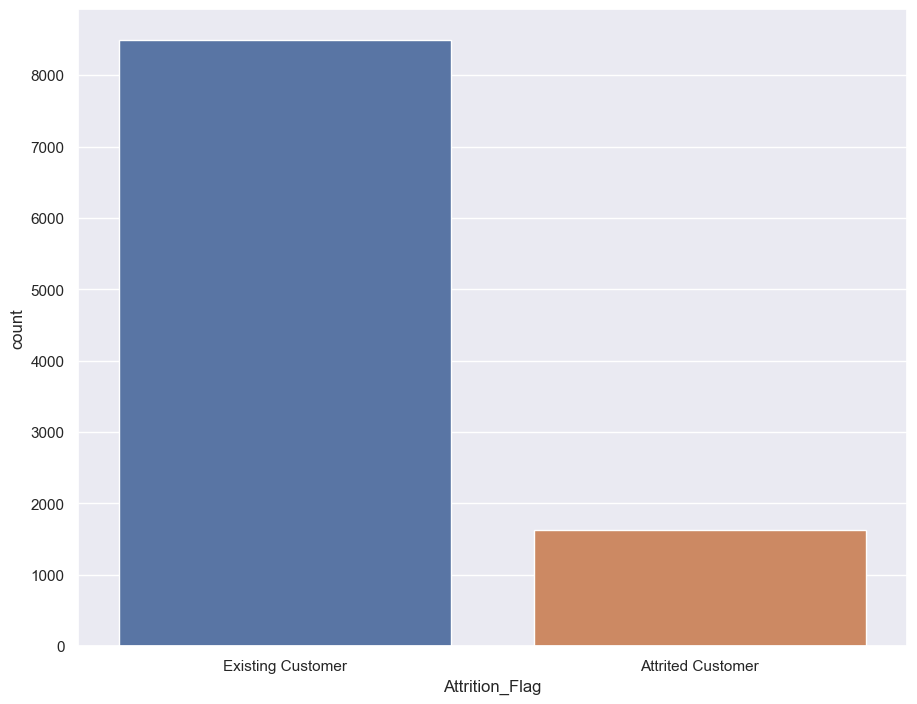

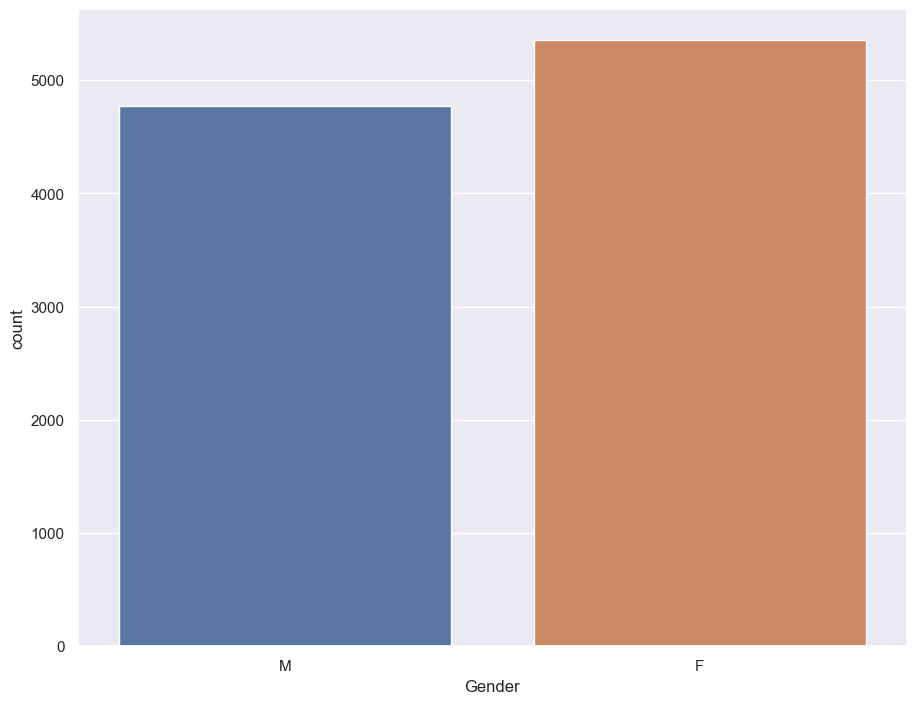

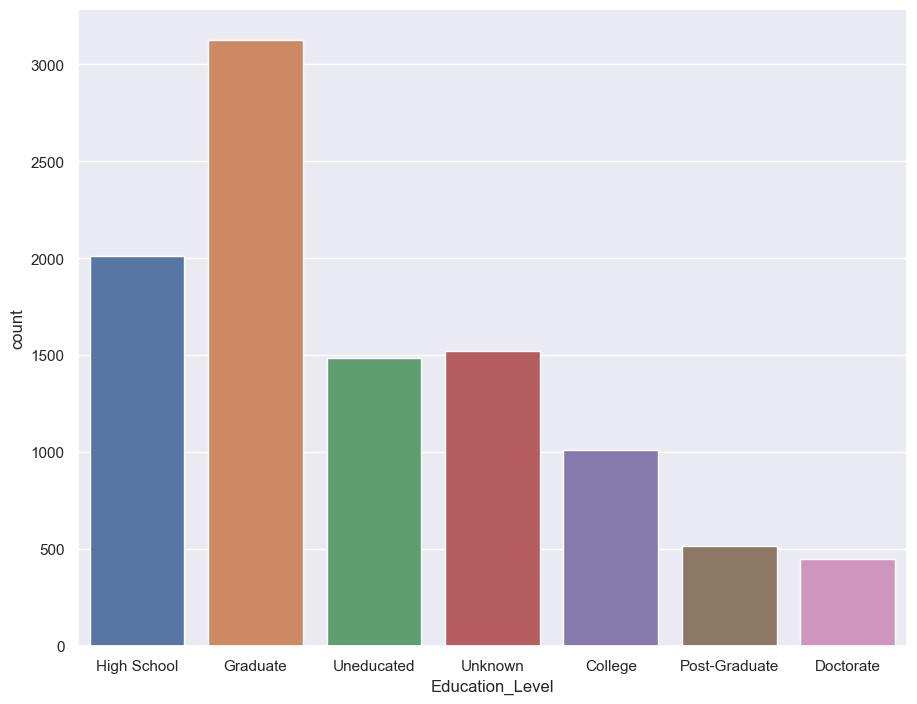

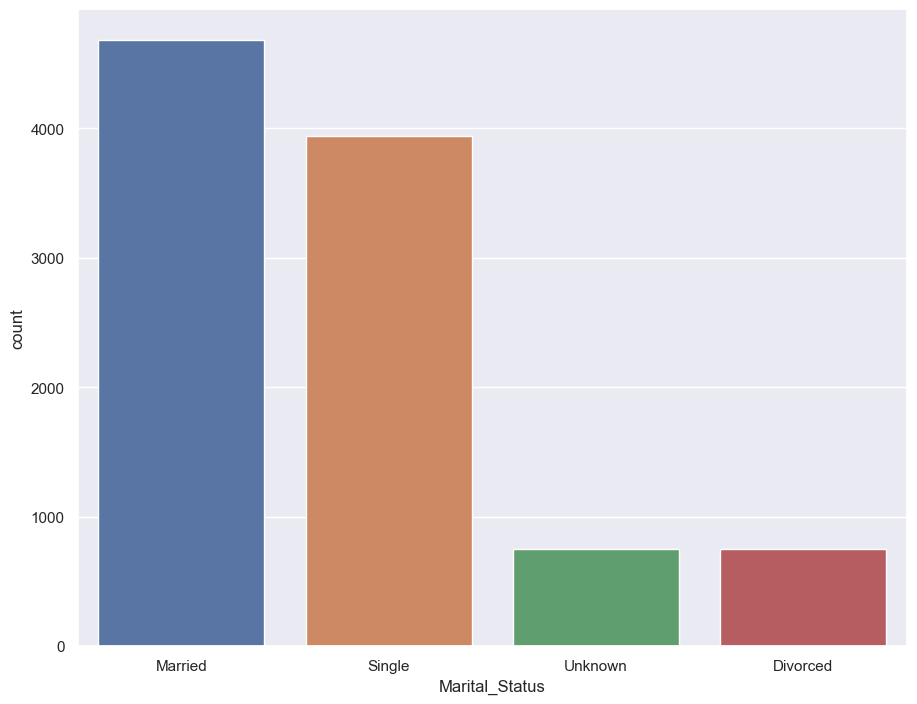

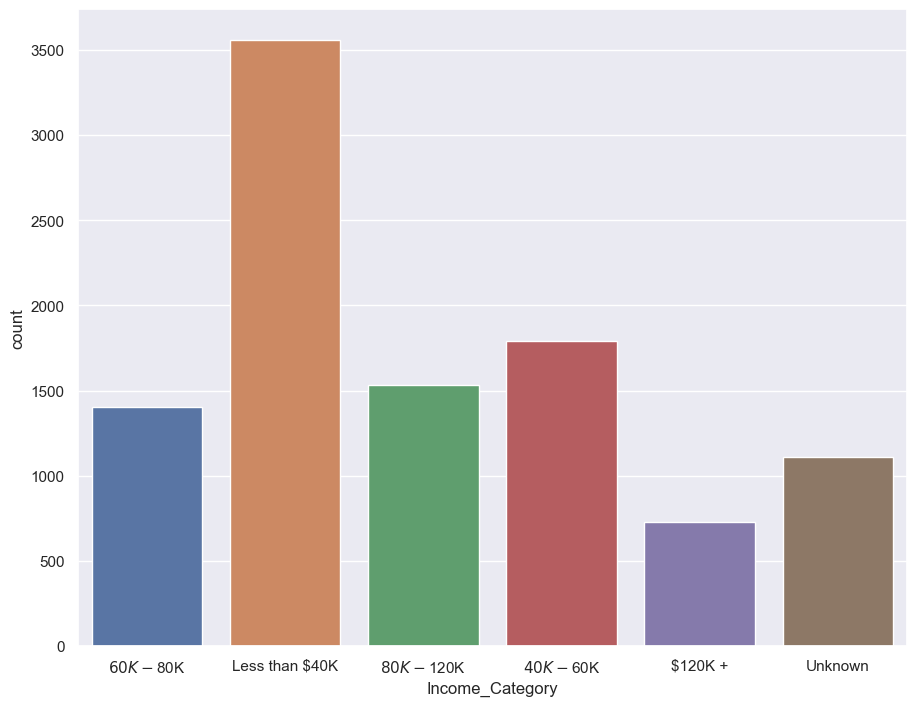

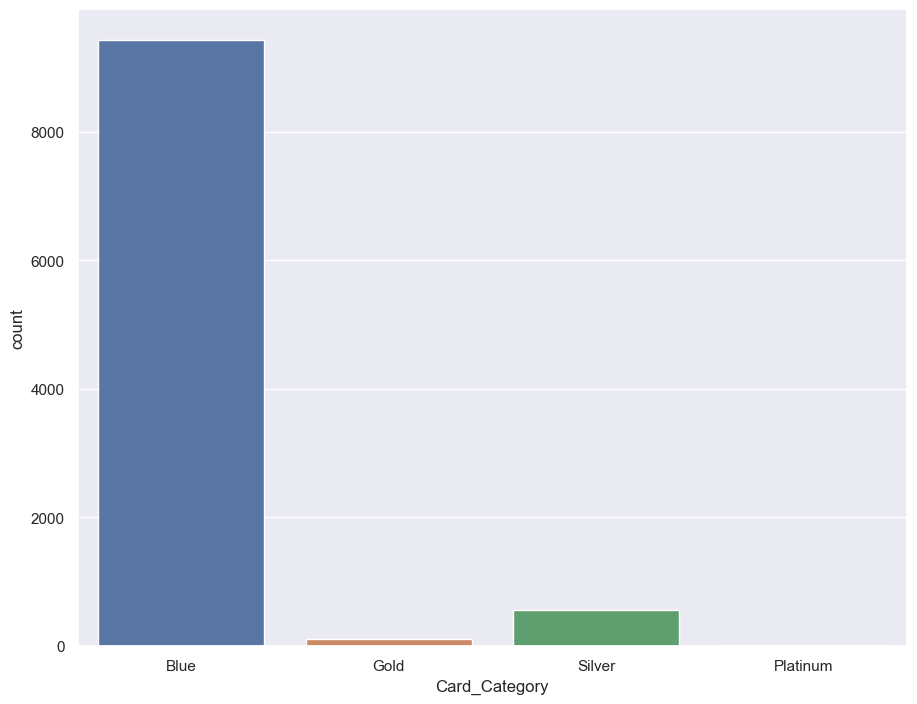

In [8]:
for i, col in enumerate(df[categorical]):
    plt.figure(i)
    sns.countplot(x=col, data=df[categorical])
    plt.savefig('Credit Card Customers categorical '+ col +'.png')

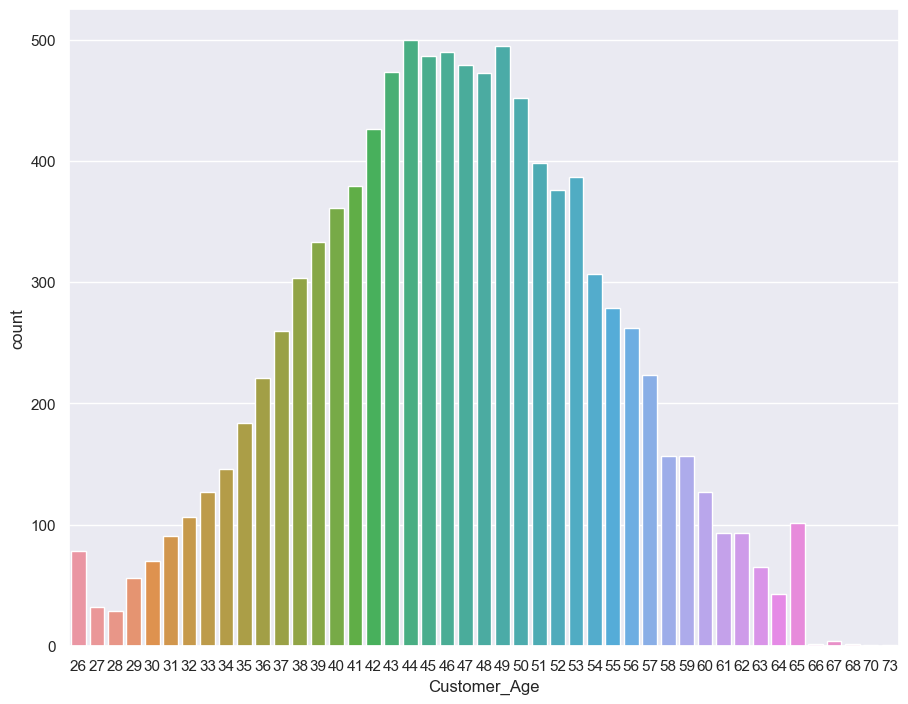

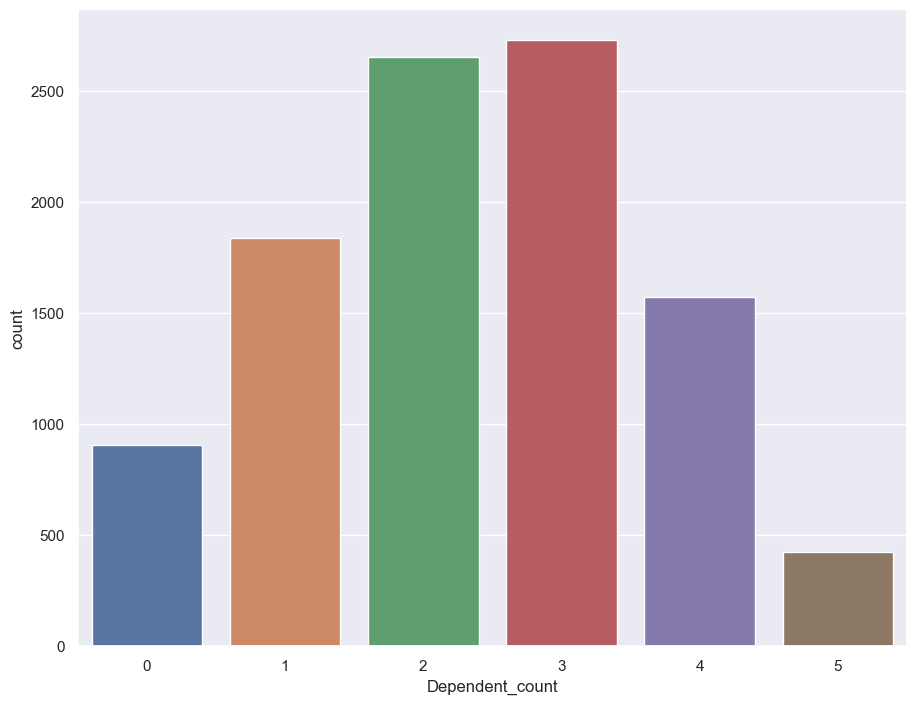

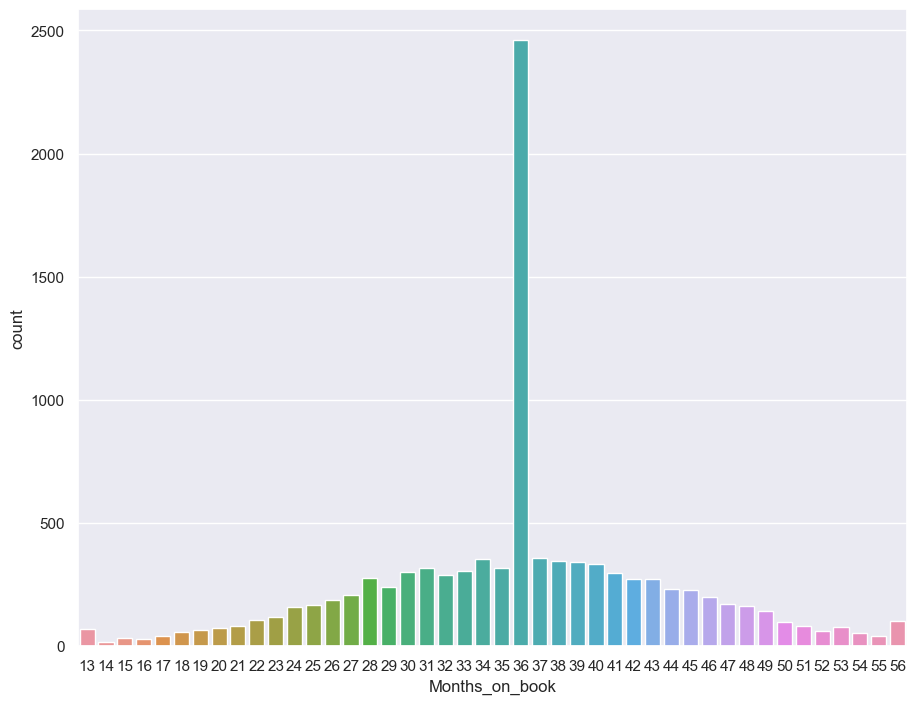

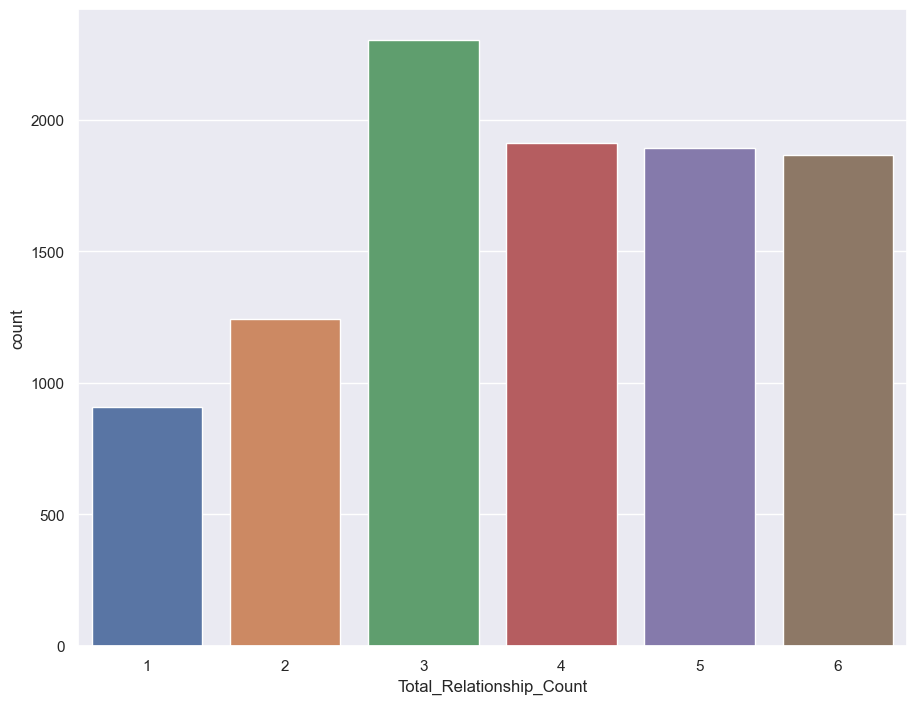

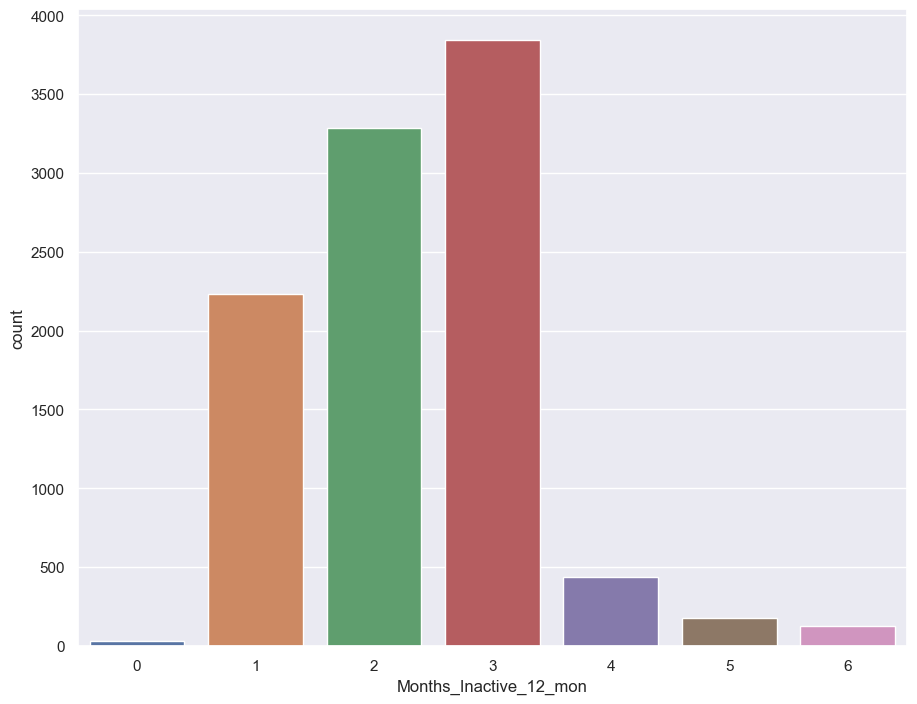

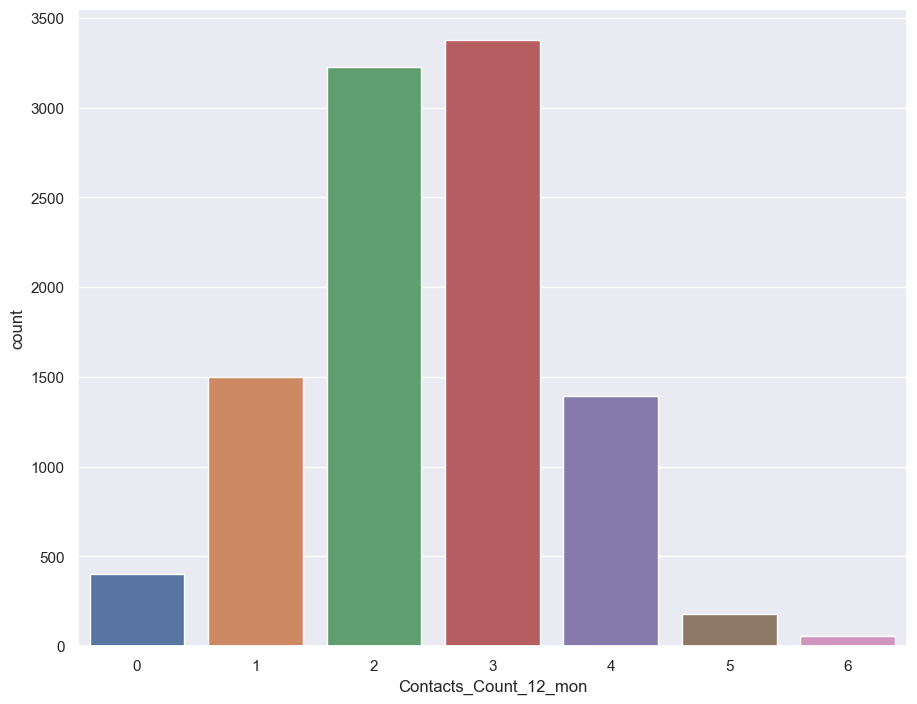

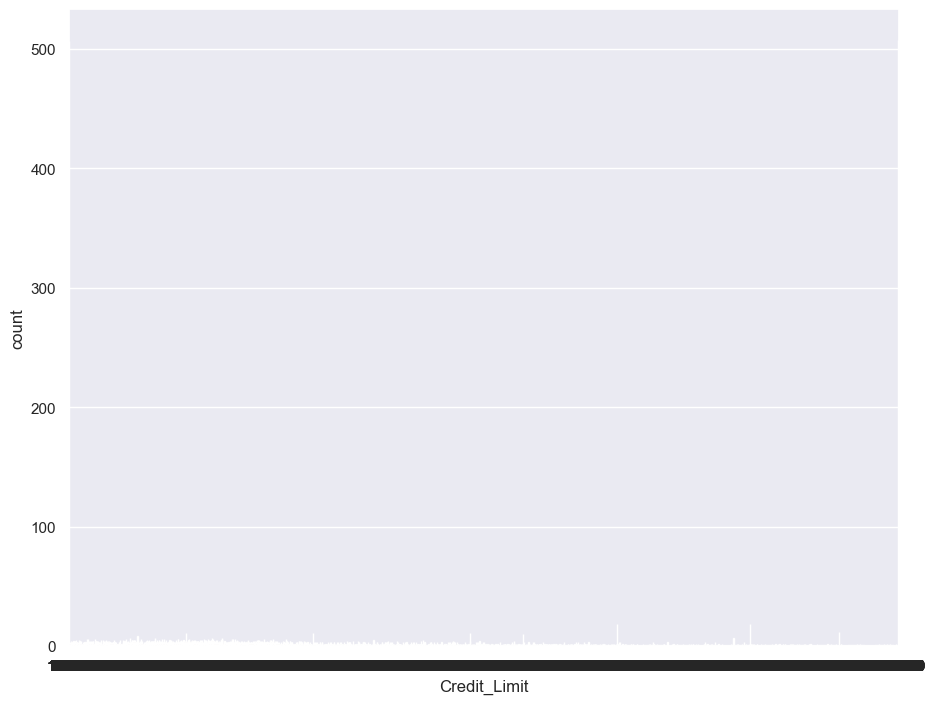

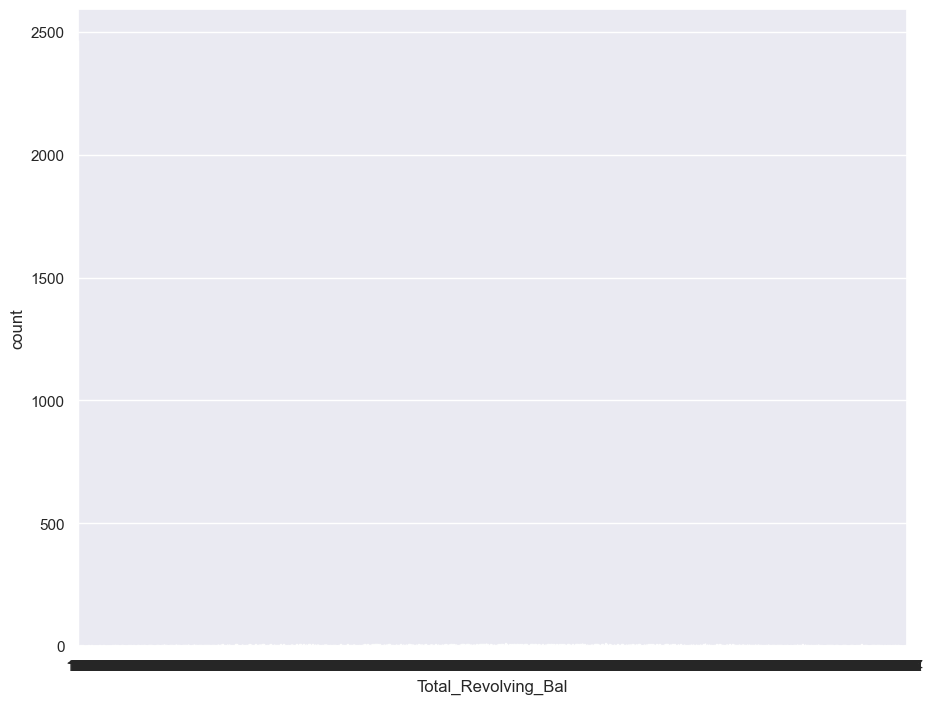

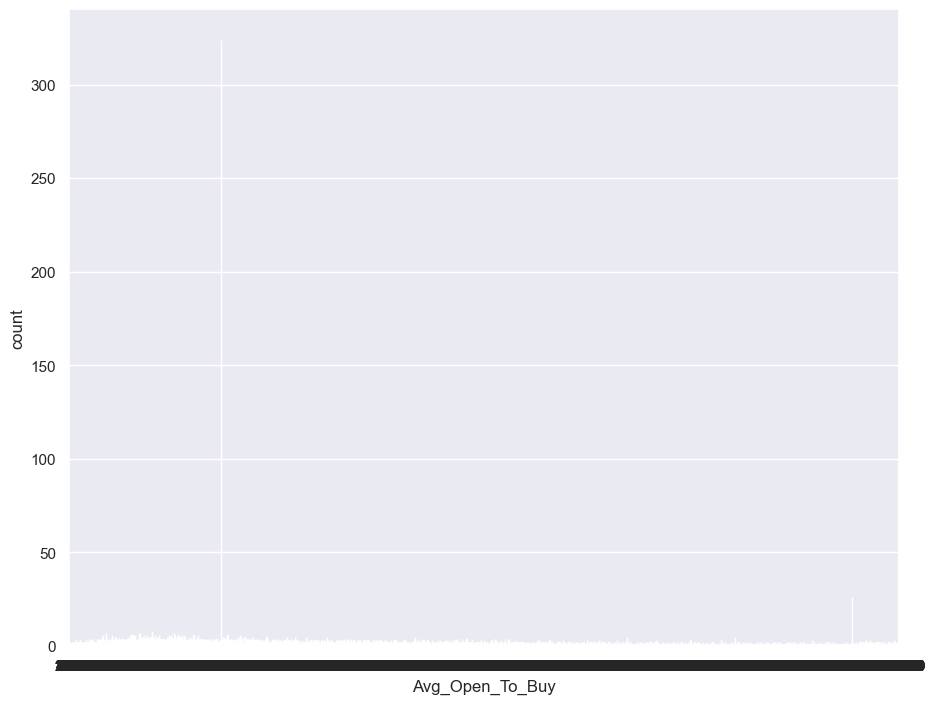

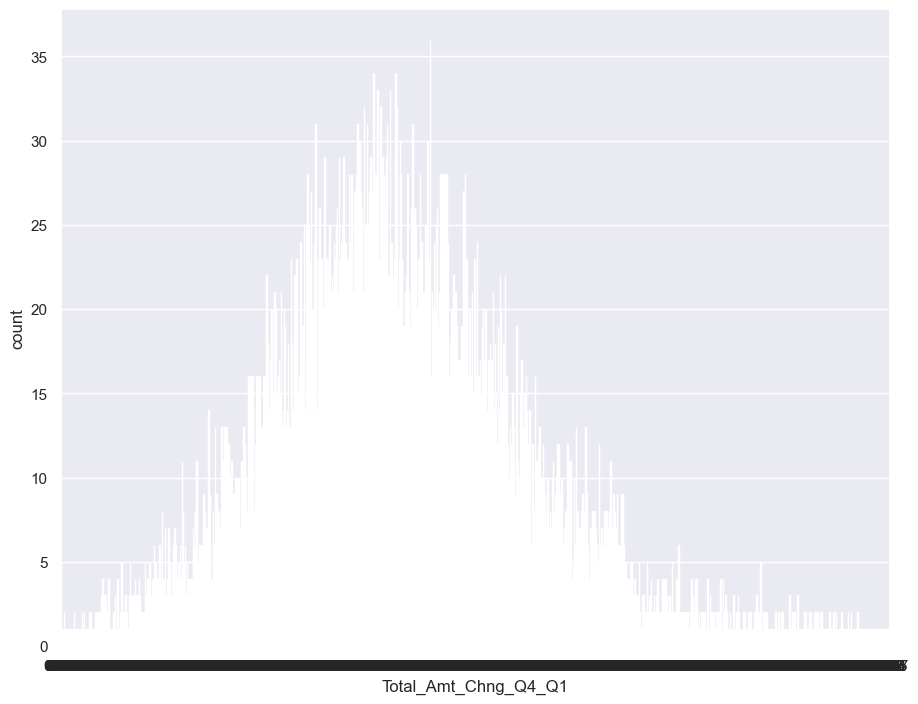

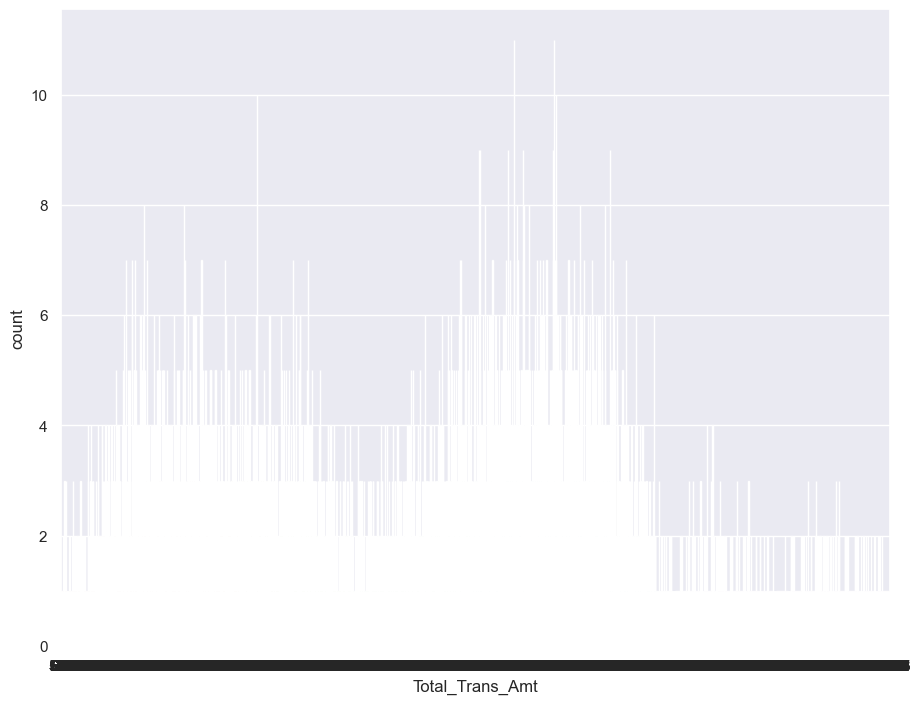

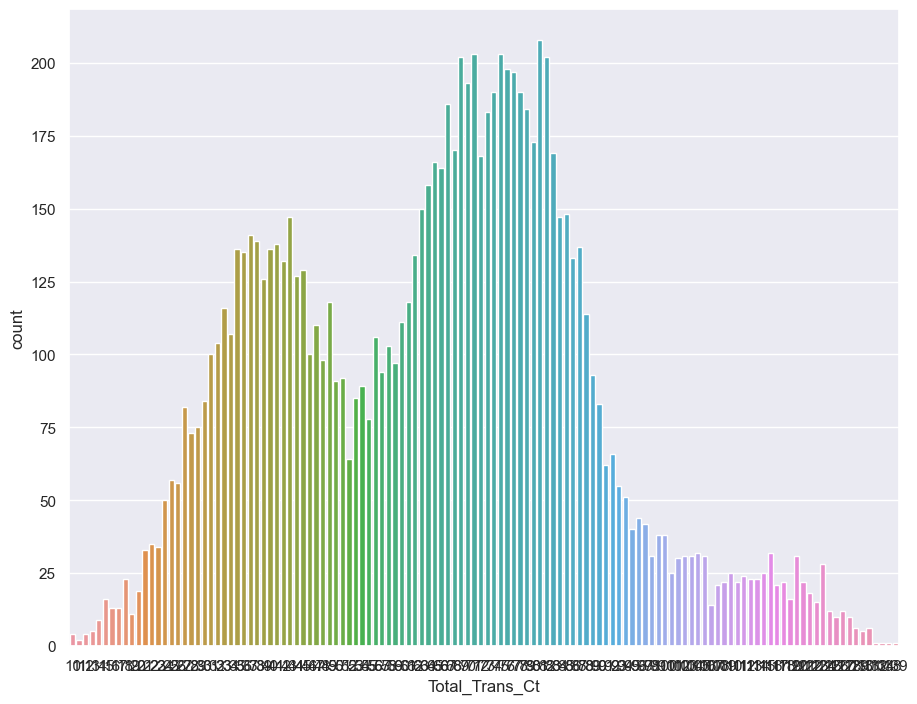

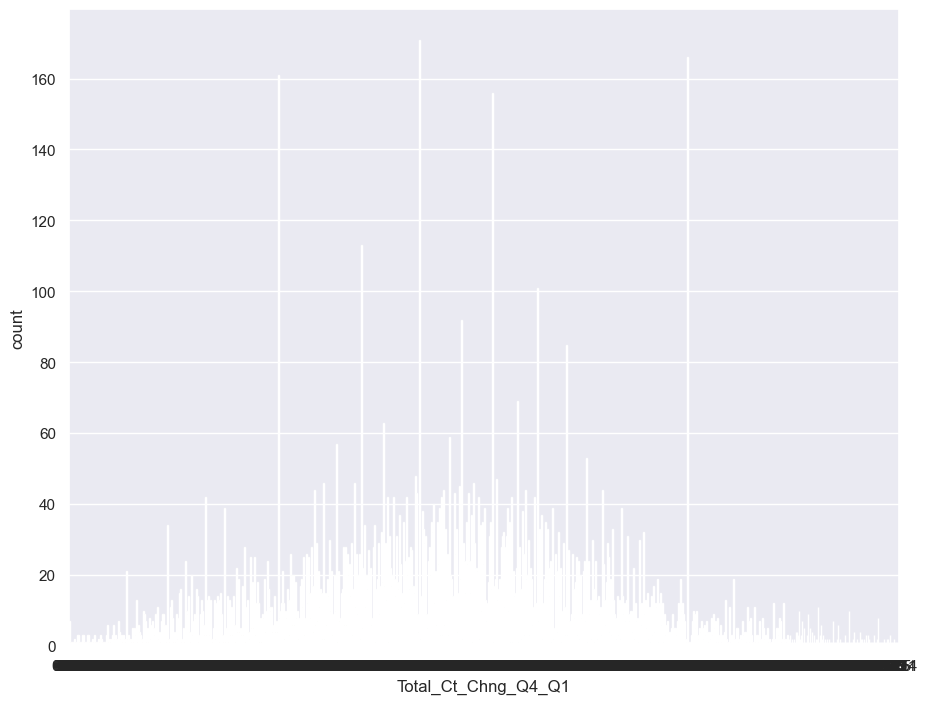

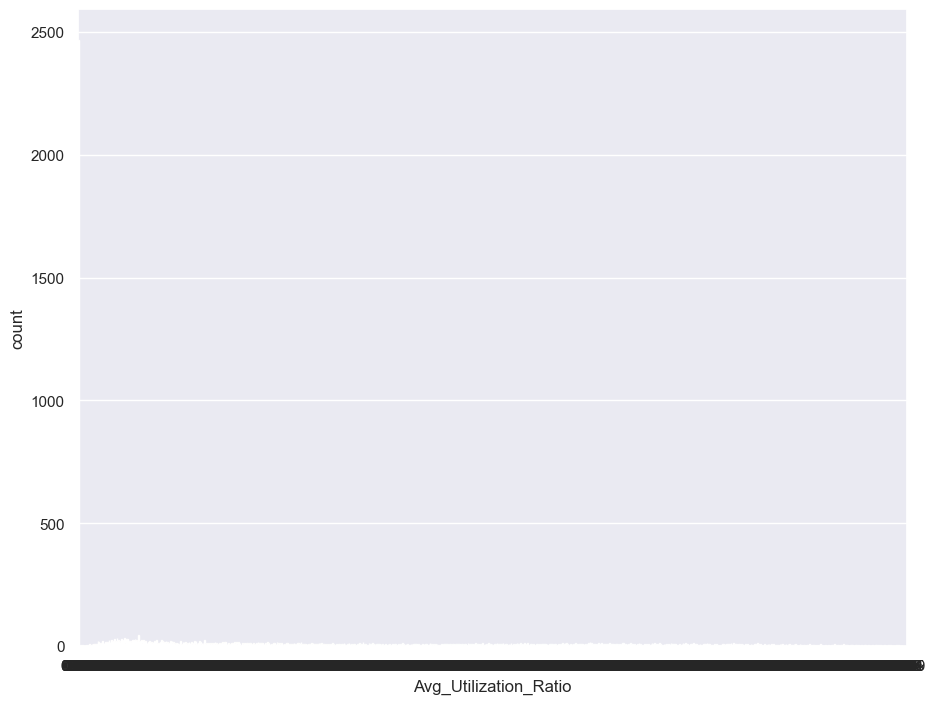

In [9]:
for i, col in enumerate(df[numerical].columns):
    plt.figure(i)
    sns.countplot(x=col, data=df[numerical])
    plt.savefig('Credit Card Customers numerical '+ col +'.png')

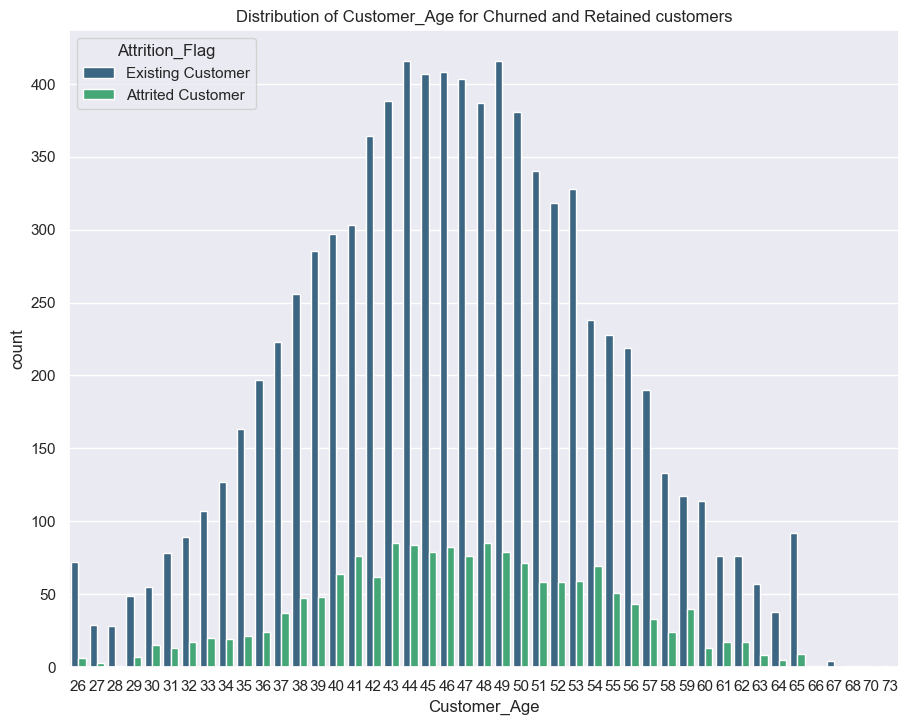

In [10]:
sns.countplot(x='Customer_Age', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Customer_Age for Churned and Retained customers")

plt.savefig('Customer_AgeforChurned and Retainedcustomers.png')
plt.show()

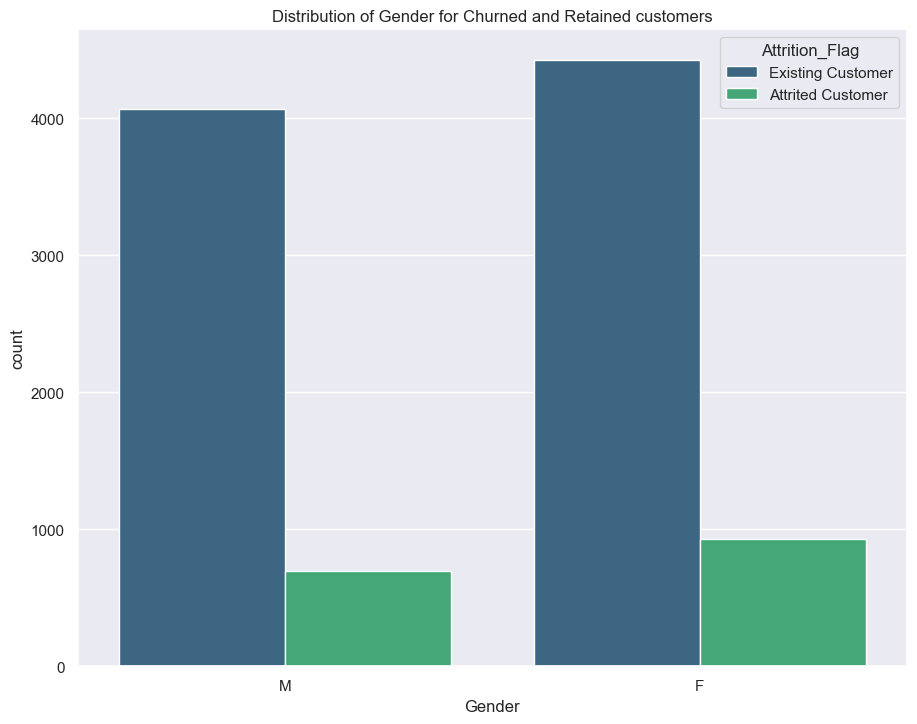

In [11]:
sns.countplot(x='Gender', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Gender for Churned and Retained customers")
plt.savefig('Distribution of Gender for Churned and Retained customers.png')

plt.show()

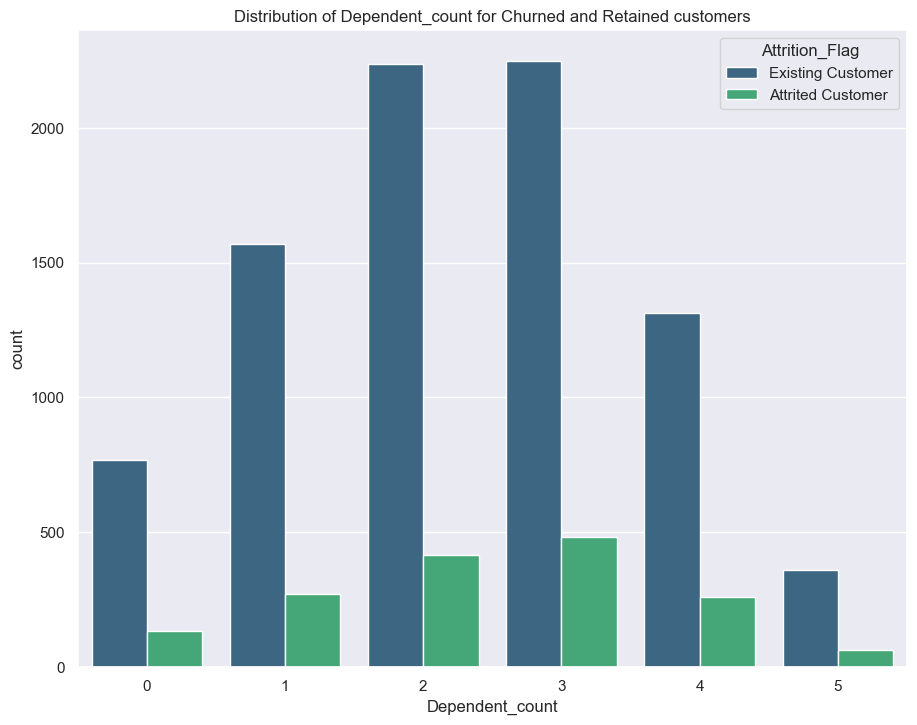

In [12]:
sns.countplot(x='Dependent_count', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Dependent_count for Churned and Retained customers")
plt.savefig('Distribution of Gender for Churned and Retained customers.png')

plt.show()

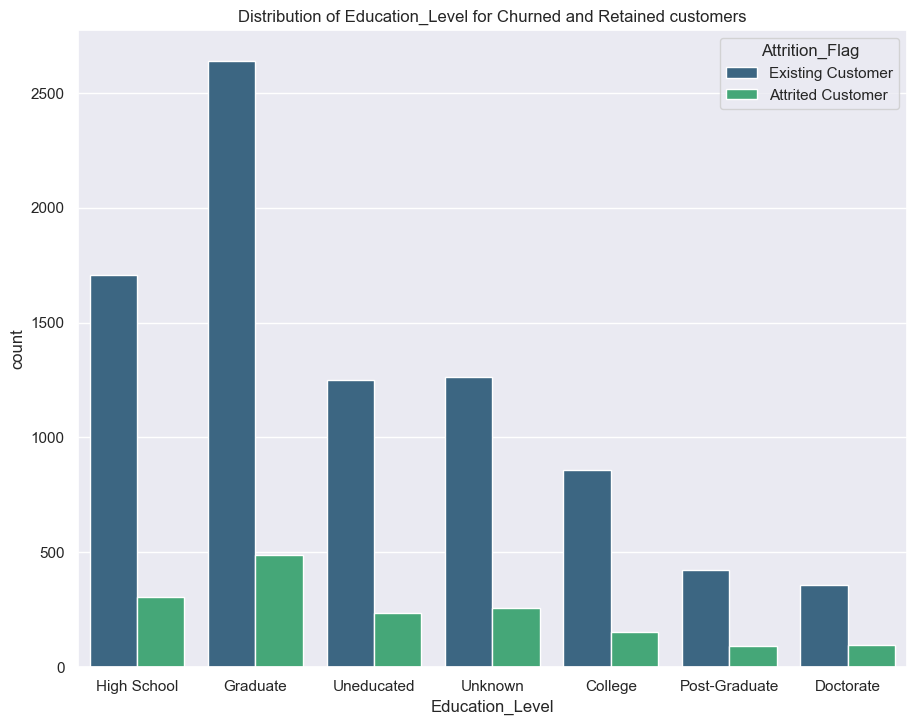

In [13]:
sns.countplot(x='Education_Level', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Education_Level for Churned and Retained customers")

plt.savefig('Distribution of Education_Level .png')

plt.show()

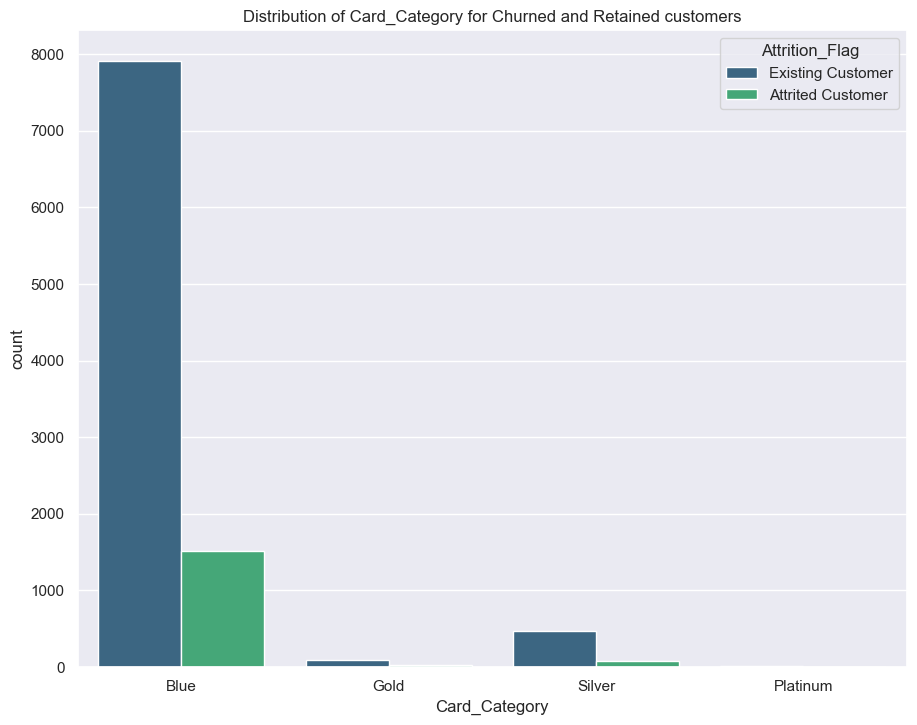

In [14]:
sns.countplot(x='Card_Category', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Card_Category for Churned and Retained customers")
plt.show()

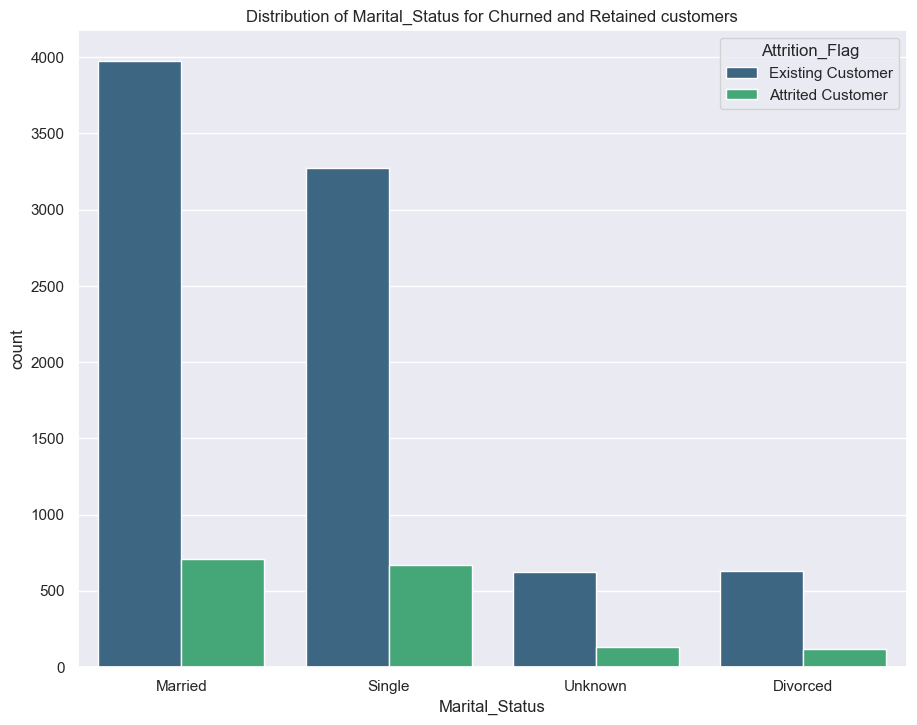

In [15]:
sns.countplot(x='Marital_Status', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Marital_Status for Churned and Retained customers")

plt.show()

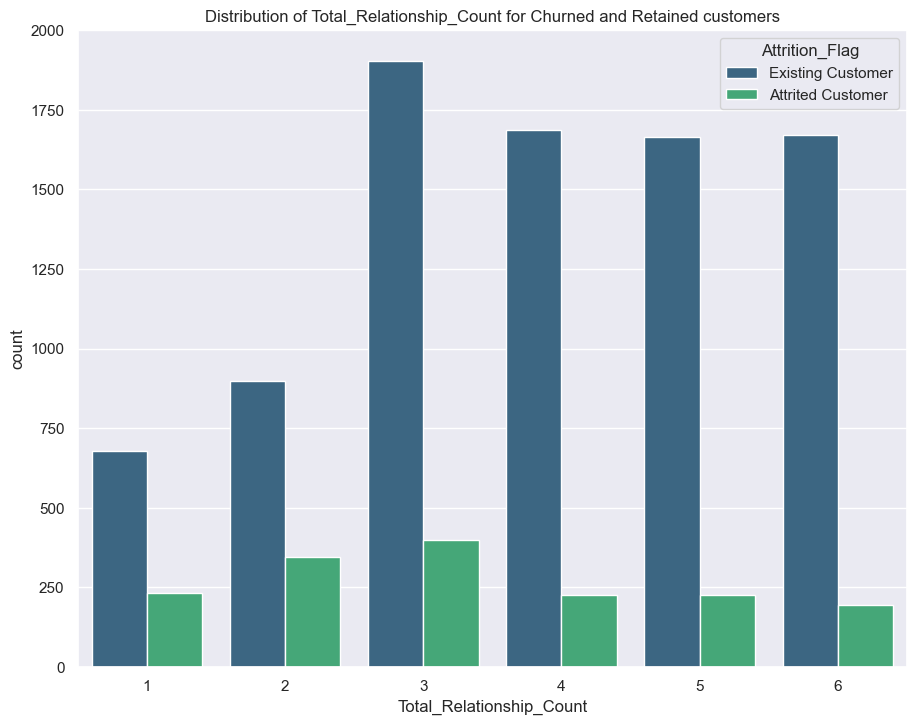

In [16]:
sns.countplot(x='Total_Relationship_Count', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Total_Relationship_Count for Churned and Retained customers")
plt.show()


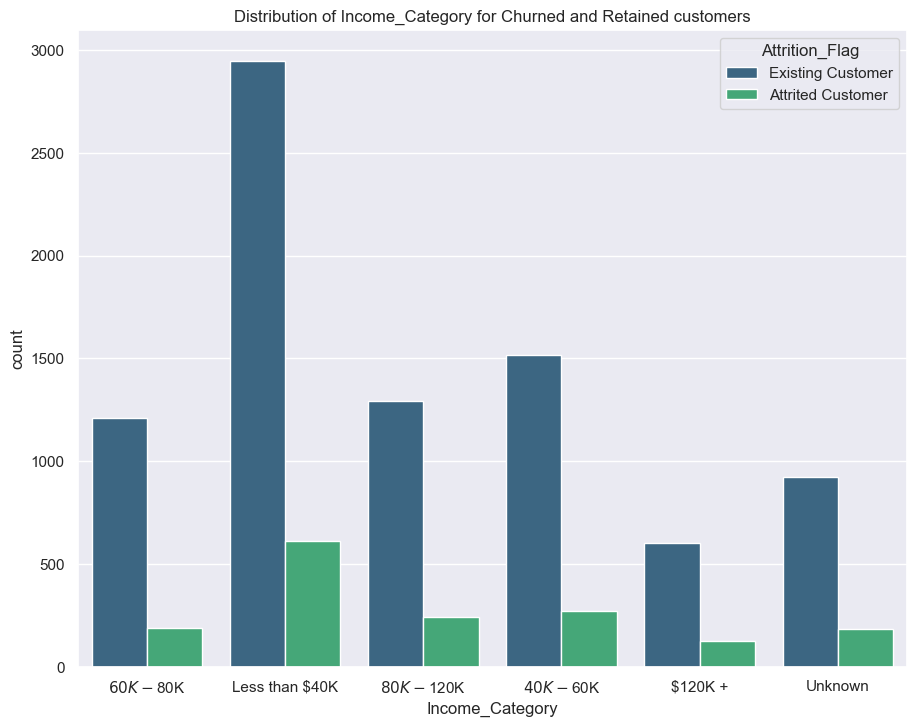

In [17]:
sns.countplot(x='Income_Category', hue='Attrition_Flag', palette='viridis', data=df)
plt.title("Distribution of Income_Category for Churned and Retained customers")

plt.savefig('Distribution of Income_Category .png')

plt.show()

In [18]:
df['Attrition_Flag'].replace(['Existing Customer', 'Attrited Customer'],
                        [0, 1], inplace=True)

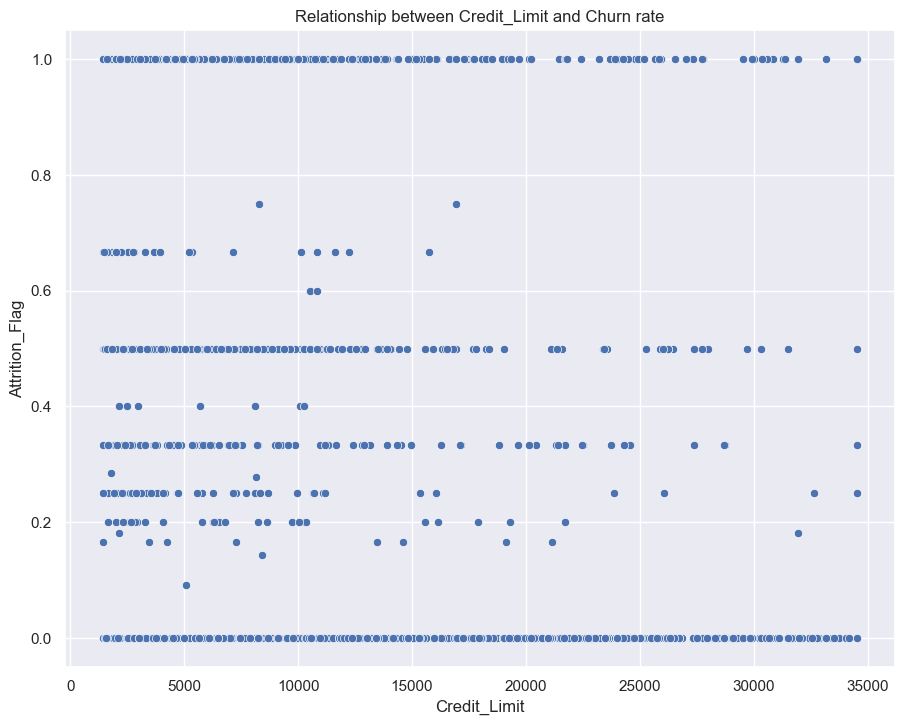

In [19]:
sns.scatterplot(x=df['Credit_Limit'],y=df.groupby('Credit_Limit').Attrition_Flag.mean())
plt.title("Relationship between Credit_Limit and Churn rate")
plt.show()

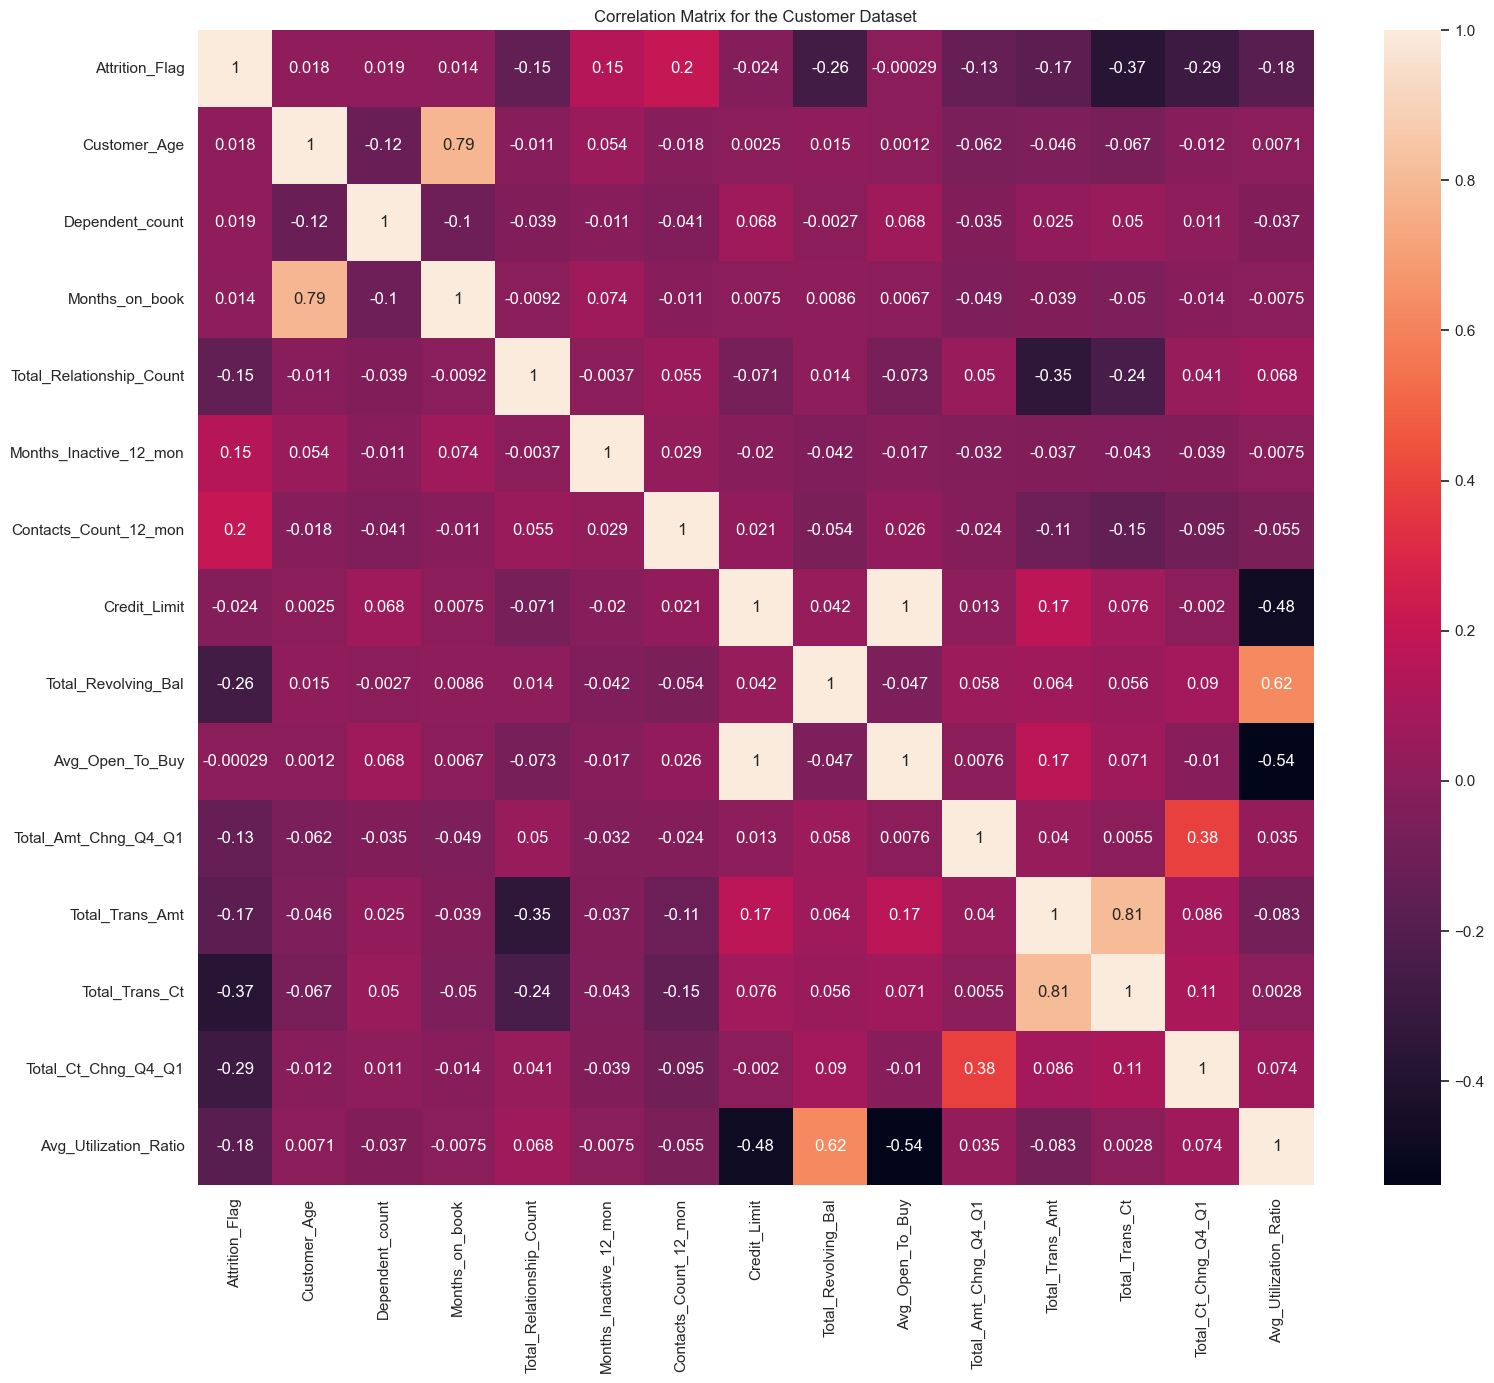

In [20]:
plt.figure(figsize=(18,15))
sns.heatmap(df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1).corr(), annot=True)
plt.title("Correlation Matrix for the Customer Dataset")
plt.show()

In [21]:
numerical =['Attrition_Flag','Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
            
           ]
_id = ['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
categorical = [i for i in df.columns if i not in _id+numerical ]
data_cat = df[categorical]

In [22]:
data_cat.columns


Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [23]:
df['Attrition_Flag'].replace(['Existing Customer', 'Attrited Customer'],
                        [0, 1], inplace=True)

In [24]:
encoded = pd.get_dummies(data_cat,drop_first=True)

data_enc = pd.concat([df.drop(data_cat.columns, axis=1), encoded], axis=1)
data_enc.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1,inplace=True)

In [25]:
#selecting features and target variable, and splitting the data
X=data_enc.drop(['Attrition_Flag'],axis=1)
y=data_enc['Attrition_Flag']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)

#cross validation
skfcv=StratifiedKFold(n_splits=5)

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#Build logistic regression pipeline
log_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('logreg',LogisticRegression())])

#cross validate logistic regression model
print(f"Cross validation score for Logistic Regression: {np.mean(cross_val_score(log_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Logistic Regression: 0.6665397465545476


Test score for Logistic Regression: 0.6548042704626335
Training score for Logistic Regression: 0.6758147512864494


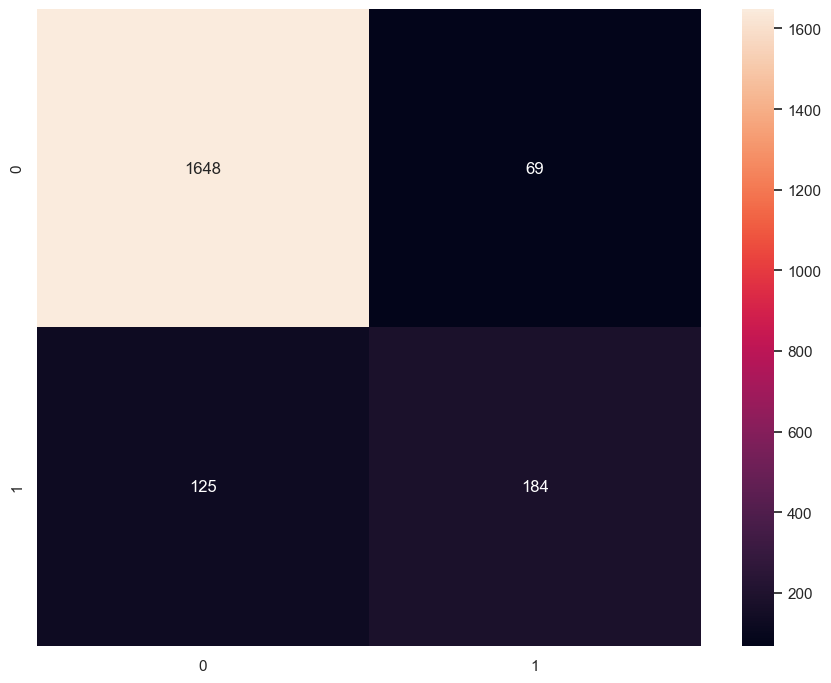

In [27]:
log_pipe.fit(X_train,y_train)
print(f"Test score for Logistic Regression: {f1_score(y_test, log_pipe.predict(X_test))}")
print(f"Training score for Logistic Regression: {f1_score(y_train, log_pipe.predict(X_train))}")
log_mat = confusion_matrix(y_test, log_pipe.predict(X_test))
sns.heatmap(log_mat, annot=True,fmt="g")
plt.show()

In [28]:
#Build Random Forest pipeline
rf_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('rfmodel',RandomForestClassifier())])

#cross validate Random Forest model
print(f"Cross validation score for Random Forest: {np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Random Forest: 0.8420795376954819


Test score for Random Forest: 0.81508078994614
Training score for Random Forest: 1.0


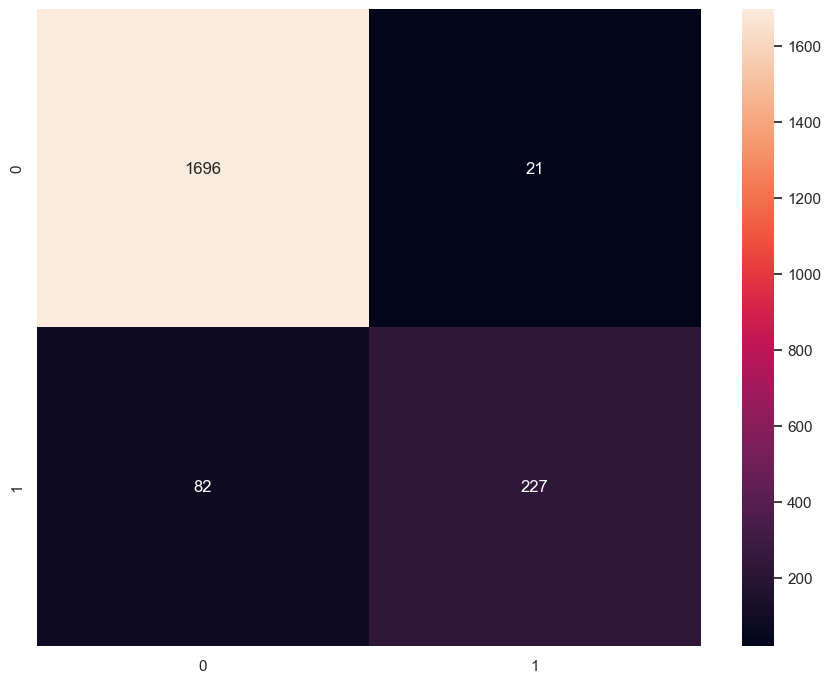

In [29]:
rf_pipe.fit(X_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, rf_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf_pipe.predict(X_train))}")
rf_mat = confusion_matrix(y_test, rf_pipe.predict(X_test))
sns.heatmap(rf_mat, annot=True,fmt="g")
plt.show()

In [30]:
#Build XGBoost pipeline
xgb_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0))])

#cross validate XGBoost model
print(f"Cross validation score for XGBoost: {np.mean(cross_val_score(xgb_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for XGBoost: 0.9092435864701318


Test score for XGBoost: 0.9063545150501673
Training score for XGBoost: 1.0


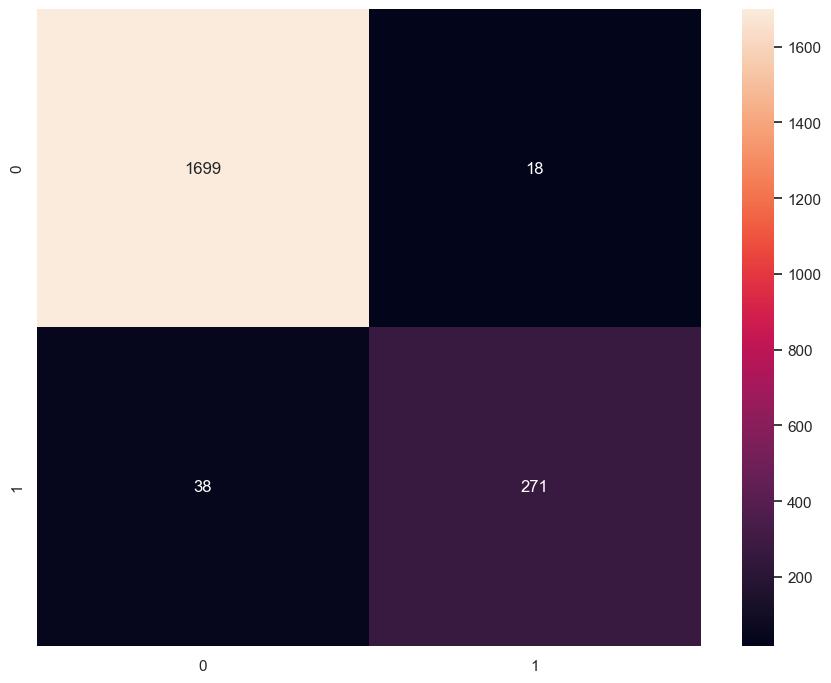

In [31]:
xgb_pipe.fit(X_train,y_train)
print(f"Test score for XGBoost: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"Training score for XGBoost: {f1_score(y_train, xgb_pipe.predict(X_train))}")
xgb_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
sns.heatmap(xgb_mat, annot=True, fmt="g")
plt.show()

In [32]:
space={'xgb__eta': (0.01,0.3),
       'xgb__max_depth': (5,20),
      'xgb__subsample': (0.4,1),
      'xgb__n_estimators': (100,250),
      'xgb__gamma':(0,5),
      'xgb__colsample_bytree':(0.4,1),
      'xgb__min_child_weight': (0.3,1)}

In [33]:
search=BayesSearchCV(xgb_pipe,search_spaces=space,n_jobs=-1,cv=skfcv, scoring='f1')

NameError: name 'BayesSearchCV' is not defined

In [ ]:
search.fit(X_train, y_train)


In [ ]:
#print the best cv score and the best parameters
print(search.best_score_)
print(search.best_params_)

In [ ]:
best_model=search.best_estimator_
print(f1_score(y_test,best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt="g")
plt.show()

In [ ]:
print(search.best_score_)
print(search.best_params_)

In [ ]:
feature_importance=pd.DataFrame(search.best_estimator_[2].feature_importances_, columns=['importance'])
feature_importance['features'] = X_train.columns

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()